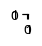

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dataframe_image as dfi
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS, get_aa_properties
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump, get_palette
from src.bootstrap import bootstrap_eval, get_pval, plot_pval
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]
mpl.rcParams['figure.dpi'] = 180

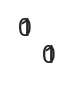

In [2]:
sns.set_palette(NEWPAL)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

In [3]:
FIGDIR = '../../../writing/230131_cedar_paper_1/figures/'

In [4]:
from sklearn.metrics import roc_auc_score, roc_curve
def get_roc_curve_auc(df, targetcol, scorecol, neg=False):
    if neg:
        fpr, tpr, _ = roc_curve(df[targetcol], -1* df[scorecol])
        auc = roc_auc_score(df[targetcol], -1* df[scorecol])
        auc01 = roc_auc_score(df[targetcol], -1* df[scorecol], max_fpr=0.1)
    else:
        fpr, tpr, _ = roc_curve(df[targetcol], df[scorecol])
        auc = roc_auc_score(df[targetcol], df[scorecol])
        auc01 = roc_auc_score(df[targetcol], df[scorecol], max_fpr=0.1)
    return fpr, tpr, auc, auc01

# init

## reloading datasets

In [5]:
cedar_related = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_related = pd.read_csv('../data/mutant/221119_prime_related_10fold.csv')
ibel = pd.read_csv('../data/mutant/221117_ibel_merged_fold.csv')
# merged = pd.read_csv('../data/mutant/221112_cedar_prime_merged_fold.csv')
nepdb = pd.read_csv('../data/mutant/230124_nepdb_filtered_scored.csv')
nepdb.head()

,Peptide,wild_type,HLA,agg_label,mut_len,wt_len,seq_id,Pos_mut,Peptide_mut,core_mut,...,core_blsm_mut_score,aliphatic_index,boman,hydrophobicity,isoelectric_point,VHSE1,VHSE3,VHSE7,VHSE8,trueHLA_EL_rank
0,AFGSAHLFR,AFGSAHLYR,HLA-A3101,1,9,9,seq_1,0,AFGSAHLFR,AFGSAHLFR,...,3,65.555556,0.837778,0.455556,10.551759,0.214444,-0.278889,0.193333,-0.192222,0.2470
1,AIANRIKFK,AIANRIKSK,HLA-A1101,0,9,9,seq_4,0,AIANRIKFK,AIANRIKFK,...,-2,108.888889,1.802222,-0.044444,11.823055,-0.048889,0.125556,0.484444,-0.125556,0.1380
2,AICKPLHYV,AICKPLHYM,HLA-A0201,0,9,9,seq_5,0,AICKPLHYV,AICKPLHYV,...,1,130.000000,-0.735556,0.755556,8.530526,0.327778,0.046667,-0.017778,0.263333,0.3610
3,AIPAMVVPNV,AIPAMVVPNA,HLA-A0201,0,10,10,seq_6,0,AIPAMVVPNV,AIPAVVPNV,...,0,146.000000,-1.637000,1.590000,6.100000,0.431000,-0.385000,-0.067000,0.446000,2.2606
4,ALEVLQSIPY,APEVLQSIPY,HLA-A0101,0,10,10,seq_7,0,ALEVLQSIPY,ALEVLQSIY,...,-3,156.000000,-0.472000,0.740000,3.849983,0.292000,-0.062000,-0.096000,0.088000,0.6230


In [6]:
cedar_aligned = pd.read_csv('../data/aligned_icore/230125_cedar_aligned_icore.csv')
prime_aligned = pd.read_csv('../data/aligned_icore/230125_prime_aligned_icore.csv')
ibel_aligned = pd.read_csv('../data/aligned_icore/230125_ibel_aligned_icore.csv')
nepdb_aligned = pd.read_csv('../data/aligned_icore/230125_nepdb_aligned_icore.csv')

In [7]:
cedar_expr = pd.read_csv('../data/pepx/230125_cedar_related_pepx_fold.csv')
prime_expr = pd.read_csv('../data/pepx/230125_prime_related_pepx.csv')
ibel_expr = pd.read_csv('../data/pepx/230125_ibel_normal_pepx.csv')
nepdb_expr = pd.read_csv('../data/pepx/230125_nepdb_normal_pepx.csv')

In [8]:
cedar_aligned_expr = pd.read_csv('../data/pepx/230125_cedar_aligned_pepx_fold.csv')
prime_aligned_expr = pd.read_csv('../data/pepx/230125_prime_aligned_pepx.csv')
ibel_aligned_expr = pd.read_csv('../data/pepx/230125_ibel_aligned_pepx.csv')
nepdb_aligned_expr = pd.read_csv('../data/pepx/230125_nepdb_aligned_pepx.csv')

In [9]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

# redo conditions

In [10]:
import itertools
# DEFINING COLS
aa_cols = ['aliphatic_index', 'boman', 'hydrophobicity', 'isoelectric_point', 'VHSE1', 'VHSE3', 'VHSE7', 'VHSE8']
mcs = []

cols_ = ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'icore_mut_score', 'EL_rank_wt_aligned', 'ratio_rank'] 

cols_.append("foreignness_score")

for L in range(0, len(cols_) + 1):
    for mc in itertools.combinations(cols_, L):
        mcs.append(list(mc))

mcs.append(aa_cols)
mcs = list(np.unique(mcs))
mcs.extend([aa_cols + [x] for x in cols_])

mcs.extend(
    [aa_cols + ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'EL_rank_wt_aligned', 'ratio_rank']])
mcs.extend([aa_cols + ['icore_dissimilarity_score', 'icore_mut_score', 'EL_rank_wt_aligned', 'ratio_rank']])
mcs.extend([aa_cols + ['icore_dissimilarity_score', 'EL_rank_wt_aligned', 'ratio_rank']])
mcs.extend([aa_cols + ['icore_blsm_mut_score', 'EL_rank_wt_aligned', 'ratio_rank']])
mcs.extend([aa_cols + ['icore_mut_score', 'EL_rank_wt_aligned', 'ratio_rank']])

mcs.extend([aa_cols + ['icore_dissimilarity_score', 'icore_blsm_mut_score', "foreignness_score"]])
mcs.extend([aa_cols + ['icore_dissimilarity_score', 'icore_mut_score', "foreignness_score"]])
mcs.extend([aa_cols + ['icore_dissimilarity_score', "foreignness_score"]])
mcs.extend([aa_cols + ['icore_blsm_mut_score', "foreignness_score"]])
mcs.extend([aa_cols + ['icore_mut_score', "foreignness_score"]])
tpm_cols = ['Total_Peptide_TPM', 'Total_Scaled_Peptide_TPM', 'Total_Gene_TPM']
mcs.extend([x+[b] for x in mcs for b in tpm_cols])

In [22]:
from copy import deepcopy
encoding_kwargs = dict(max_len=12, encoding='onehot', rank_col=['EL_rank_mut'], pep_col=['icore_mut'],
                       blosum_matrix=None, mask=False, add_rank=True, add_aaprop=False, 
                       remove_pep=False, standardize=True)

# weighting : Inv Shannon, None, Mask
# weighting tuple order : (Invert, ic name, ic dict, mask)
weighting = [(True, 'Shannon', ics_shannon, False), 
             (False, 'None', None, False), 
             (False, 'Mask', ics_shannon, True)]

# find from list of raws which conditions are not here and run them...
mcs_out = deepcopy(mcs)
# # stupid filter
# xd = []
# filtered = !ls "../output/230308_aligned_exprscore_addwtrank_foreignness/raw" | grep onehot | grep featimp | grep Inverted-KL

# for x in filtered:
#     xd.append(x.split('EL_rank_mut_')[1].replace('.csv', ''))
    
# mcs2 = [x for x in mcs_out if '-' not in xd]
# xd]
# len(mcs2)

In [23]:
filtered = filter(lambda x: 'onehot' in x and 'featimp' in x and 'Inverted-KL'in x, os.listdir('../output/230308_aligned_exprscore_addwtrank_foreignness/raw'))
filtered = [x.split('EL_rank_mut_')[1].replace('.csv','') for x in filtered]

In [24]:
len(filtered), filtered[0]

(226,
 'icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank-foreignness_score-Total_Gene_TPM')

In [ ]:
filtered = filter(lambda x: 'onehot' in x and 'featimp' in x and 'Inverted-KL'in x, os.listdir('/home/projects/vaccine/peolpe/yatwan/cedar/output/230308_aligned_exprscore_addwtrank_foreignness/raw'))
filtered = [x.split('EL_rank_mut_')[1].replace('.csv','') for x in filtered]

In [25]:
mcs2 = [x for x in mcs_out if '-'.join(x) not in filtered]
len(mcs2), mcs2[:5]

(150,
 [[],
  ['EL_rank_wt_aligned', 'ratio_rank'],
  ['EL_rank_wt_aligned', 'ratio_rank', 'foreignness_score'],
  ['icore_blsm_mut_score', 'EL_rank_wt_aligned', 'ratio_rank'],
  ['icore_blsm_mut_score',
   'EL_rank_wt_aligned',
   'ratio_rank',
   'foreignness_score']])